# How to combine Pytorch-Transformers (updated from Pytorch-pretrained-bert) with Fastai

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import *
import torch
import torch.optim as optim

from fastai import *
from fastai.text import *
from fastai.callbacks import *

from fastai.basic_train import *
from fastai.basic_train import BasicLearner
import sys
from sklearn.model_selection import train_test_split

In [3]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16= True,
    bs=64,
    discriminative=False,
    max_seq_len=128,
)

We'll be using the pytorch-pretrained-bert package, so install it if you do not have it yet!

BERT requires a special wordpiece tokenizer and a vocabulary to go along with that. Thankfully, the pytorch-pretrained-bert package provides all of that within the handy `BertTokenizer` class.

# Data

In [4]:
#from pytorch_pretrained_bert import BertTokenizer
from pytorch_transformers import *

bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

FastAI has its own conventions for handling tokenization, so we'll need to wrap the tokenizer within a different class. This is a bit confusing but shouldn't be that much of a hassle.

Notice we add the \[CLS] and \[SEP] special tokens to the start and end of the sequence here.


In [5]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

Slightly confusingly, we further need to wrap the tokenizer above in a `Tokenizer` object. 

In [6]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

Now, we need to make sure fastai uses the same mapping from wordpiece to integer as BERT originally did. Again, fastai has its own conventions on vocabulary so we'll be passing the vocabulary internal to the `BertTokenizer` and constructing a fastai `Vocab` object to use for preprocessing.

In [7]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))
DATA_PATH = Path("./data/")


Now we have all the pieces we need to make BERT work with fastai! We'll load the data into dataframes and construct a validation set.

In [8]:
DATA = pd.read_csv(DATA_PATH/"toxic_comment.csv")

# Use a smaller dataset to test
#DATA = pd.read_csv(DATA_PATH/"toxic_comment.csv")[0:10000]

In [9]:

DATA_test = pd.read_csv(DATA_PATH/"toxic_test.csv")
train, val = train_test_split(DATA)

if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [10]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


Now, we can build the databunch using the tokenizer and vocabulary we build above. Notice we're passing the `include_bos=False` and `include_eos=False` options. This is to prevent fastai from adding its own SOS/EOS tokens that will interfere with BERT's SOS/EOS tokens.

In [11]:
databunch = TextDataBunch.from_df(".", train, val, DATA_test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [16]:
DATA_BUNCH = Path(DATA_PATH/"databunch_full")
DATA_BUNCH.mkdir(exist_ok = True)                

In [15]:
databunch.save(DATA_BUNCH/"data_save.pkl")

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [17]:
databunch = load_data(DATA_BUNCH)


In [12]:
databunch

TextClasDataBunch;

Train: LabelList (7500 items)
x: TextList
[CLS] what ? who changed again it ? i fixed several times . please stop van ##dal ##ising this page ! ! [SEP],[CLS] expanding on the legal ##ity of step ##mi ##x is step ##mi ##x really legal ? the small inclusion into the article makes it appear all ok ##ey do ##key , but with songs from dd ##r and such , is it really all that legal ? [SEP],[CLS] " je ##z ##ta ##h , the explain ##ation above ( that since the article of the 1982 war is called 1982 lebanon war and since that war only since 2006 has been called the first lebanon war only in and to israel , then this war should be called 2006 lebanon war is incorrect and that logic is not supported by wikipedia policy . the 2006 lebanon has very little credentials ( as i am proving above . ) israel - hezbollah war carries no po ##v implications ( the excuse george . sal ##iba named above is purely original and cannot be heard anywhere else in all seriousness . ) using his logic

# Model

Now with the data in place, we will prepare the model and loss functions. Again, the pytorch-pretrained-bert package gives us a sequence classifier based on BERT straight out of the box.

In [13]:
#from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

Since this is a multilabel classification problem, we're using `BCEWithLogitsLoss`

In [14]:
loss_func = nn.BCEWithLogitsLoss()

In [15]:
# The more recent version fastai implemented exactly this version thus you could just directly call a partial funtion
# accuracy_thresh
def accuracy_thresh2(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Computes accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh).byte()==y_true.byte()).float().mean()


In [16]:
acc_02 = partial(accuracy_thresh2, thresh=0.25)

In [17]:
def loss_batch_bert(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    out = out[0]
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

In [18]:
# To change the loss_batch function in the loaded fastai module
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

And now we can build the `Learner`.

In [20]:
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = acc_02
)

And we're done! All the rest is fastai magic. For example, you can use half-precision training simply by calling `learner.to_fp16()`

In [21]:
if config.use_fp16: learner = learner.to_fp16()

We can also use the learning rate finder.

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


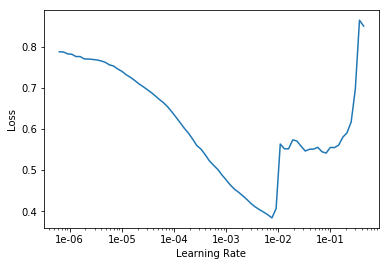

In [23]:
learner.recorder.plot()

And now to actually train the model.

In [24]:
learner.fit_one_cycle(1, max_lr= 1e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh2,time
0,0.110415,0.068449,0.966200,00:57


In [34]:
learner.fit_one_cycle(1, max_lr= 1e-05, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh2,time
0,0.032895,0.038121,0.980636,17:05


See how simple that was?

In [35]:
learner.save("full_model_learner", return_path = True)
#learner.load("./models/small_model.pth")
#PosixPath('data/databunch_small/models/small_model.pth')

PosixPath('data/databunch_full/models/full_model_learner.pth')

# Predictions

Now to generate predictions. This is where you can get tripped up because the `databunch` does not load data in sorted order. So we'll have to do reorder the generated predictions to match their original order.

In [25]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [26]:
test_preds = get_preds_as_nparray(DatasetType.Test)

You can generate a submission if you like, though you'll probably want to use a different set of configurations.

In [43]:
sample_submission = pd.read_csv(DATA_PATH / "jigsaw_sample_submission.csv")
if config.testing: sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds
sample_submission.to_csv("predictions.csv", index=False)